In [34]:
# !gdown --id 1GaTMURqIQTjtalbNVAyVgPIEis21A0r8

In [35]:
# !unzip -q './FER-2013.zip'

In [36]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize
from torchvision.io import read_image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
random_state = 59
np.random.seed(random_state)

if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

cuda


#### 1. Data Preparation

In [38]:
train_dir = '/content/train'
test_dir = '/content/test'

classes = os.listdir(train_dir)

label2idx = {label:idx for idx, label in enumerate(classes)}
idx2label = {idx:label for label, idx in label2idx.items()}

In [39]:
test_img_path = '/content/train/fear/Training_10018621.jpg'
img = cv2.imread(test_img_path)
img_height , img_width = (128, 128)
print (f'Image height: {img_height}')
print (f'Image width: {img_width}')

Image height: 128
Image width: 128


#### 2. DataLoader

In [40]:
class ImageDataset(Dataset):
    def __init__(self, img_dir, norm, label2idx, split='train', train_ratio=0.8):
        self.resize = Resize((img_height, img_width))
        self.norm = norm
        self.split = split
        self.train_ratio = train_ratio
        self.img_dir = img_dir
        self.label2idx = label2idx
        self.img_paths, self.img_labels = self.read_img_files()

        if split in ['train','val'] and 'train' in img_dir.lower():
            train_data , val_data = train_test_split(
                list(zip(self.img_paths, self.img_labels)),
                train_size = train_ratio,
                random_state = random_state,
                stratify = self.img_labels)

            if split  == 'train':
                self.img_paths, self.img_labels = zip(*train_data)
            elif split == 'val':
                self.img_paths, self.img_labels = zip(*val_data)

    def read_img_files ( self ) :
        img_paths = []
        img_labels = []
        for cls in self.label2idx.keys() :
            for img in os. listdir(os.path.join(self.img_dir, cls)) :
                img_paths.append(os.path.join(self.img_dir,cls, img))
                img_labels.append(cls)

        return img_paths , img_labels

    def __len__(self):
        return len(self.img_paths)

    def __getitem__ (self,idx ) :
        img_path = self.img_paths[idx]
        cls = self.img_labels [idx]
        img = self.resize(read_image(img_path))
        img = img.type(torch.float32)
        label = self.label2idx[cls]
        if self.norm:
            img = (img /127.5) - 1
        return img , label


In [41]:
batch_size = 256

train_dataset = ImageDataset(train_dir, True, label2idx, 'train')
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

val_dataset = ImageDataset(train_dir, True, label2idx, 'val')
val_loader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        shuffle=False)

test_dataset = ImageDataset(test_dir, True, label2idx, 'test')
test_loader = DataLoader(test_dataset,
                         batch_size=batch_size,
                         shuffle=False)

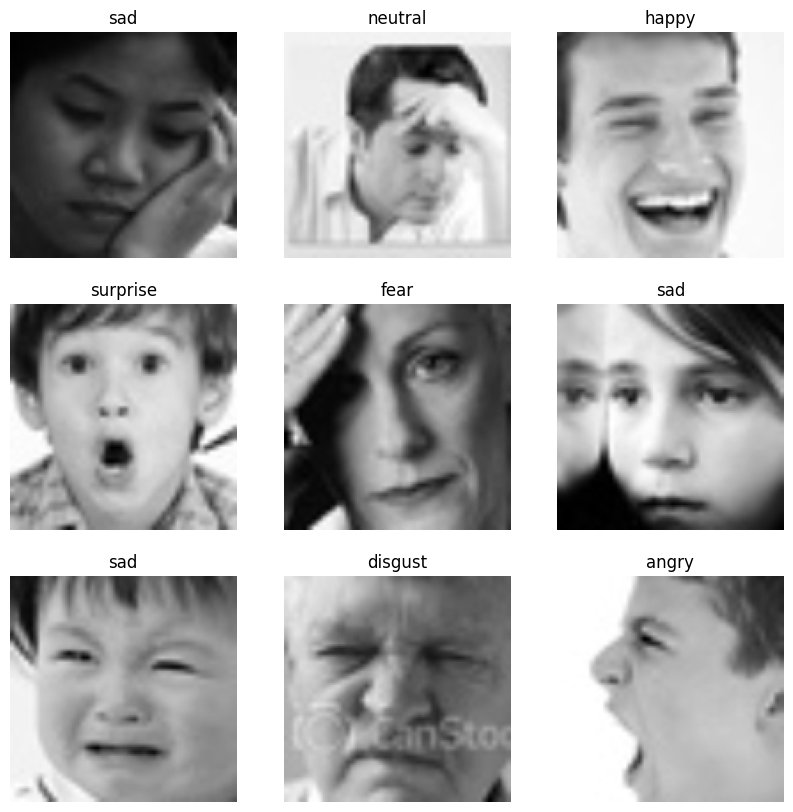

In [42]:
image_batch, label_batch = next(iter(train_loader))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  minv = image_batch[i].numpy().min()
  maxv = image_batch[i].numpy().max()
  plt.imshow(np.squeeze(image_batch[i].numpy()), vmin=minv, vmax=maxv, cmap="gray")
  label = label_batch[i]
  plt.title(idx2label[label.item()])
  plt.axis("off")

#### 3. Build MLPs Model

In [43]:
# class MLP(nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim):
#         super().__init__()
#         self.linear1 = nn.Linear(input_dim, hidden_dim * 4)
#         self.linear2 = nn.Linear(hidden_dim * 4, hidden_dim * 2)
#         self.linear3 = nn.Linear(hidden_dim * 2, hidden_dim)
#         self.output = nn.Linear(hidden_dim, output_dim)

#     def forward(self, x):
#         x = nn.Flatten()(x)
#         x = self.linear1(x)
#         x = F.relu(x)
#         x = self.linear2(x)
#         x = F.relu(x)
#         x = self.linear3(x)
#         x = F.relu(x)
#         out = self.output(x)
#         return out.squeeze(1)

# class MLP(nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim):
#         super().__init__()
#         self.linear1 = nn.Linear(input_dim, hidden_dim * 4)
#         self.linear2 = nn.Linear(hidden_dim * 4, hidden_dim * 2)
#         self.output = nn.Linear(hidden_dim * 2, output_dim)

#     def forward(self, x):
#         x = nn.Flatten()(x)
#         x = self.linear1(x)
#         x = F.relu(x)
#         x = self.linear2(x)
#         x = F.relu(x)
#         out = self.output(x)
#         return out.squeeze(1)

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        out = self.output(x)
        return out.squeeze(1)

In [44]:
input_dims = img_height * img_width
output_dims = len(classes)
hidden_dims = 64

model = MLP(input_dim=input_dims,
            hidden_dim=hidden_dims,
            output_dim=output_dims).to(device)

In [45]:
lr = 1e-2

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [46]:
def compute_accuracy(y_hat, y_true):
    _, y_hat = torch.max(y_hat, dim=1)
    correct = (y_hat == y_true).sum().item()
    accuracy = correct / len(y_true)
    return accuracy

#### 4. Training

In [47]:
epochs = 40

train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    # Training loop
    train_loss = 0.0
    train_target = []
    train_predict = []
    model.train()

    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)

        optimizer.zero_grad()
        outputs = model(X_samples)
        loss = criterion(outputs, y_samples)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_predict.append(outputs.detach().cpu())
        train_target.append(y_samples.cpu())

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    train_predict = torch.cat(train_predict)
    train_target = torch.cat(train_target)
    train_acc = compute_accuracy(train_predict, train_target)
    train_accs.append(train_acc)

    # Validation loop
    val_loss = 0.0
    val_target = []
    val_predict = []
    model.eval()

    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)

            outputs = model(X_samples)
            val_loss += criterion(outputs, y_samples).item()

            val_predict.append(outputs.cpu())
            val_target.append(y_samples.cpu())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_acc = compute_accuracy(val_predict, val_target)
    val_accs.append(val_acc)

    print(f"\nEPOCH {epoch + 1}:\tTraining loss: {train_loss:.3f}\tValidation loss: {val_loss:.3f}\t"
          f"Training accuracy: {train_acc:.3f}\tValidation accuracy: {val_acc:.3f}")


EPOCH 1:	Training loss: 1.841	Validation loss: 1.794	Training accuracy: 0.255	Validation accuracy: 0.283

EPOCH 2:	Training loss: 1.764	Validation loss: 1.753	Training accuracy: 0.298	Validation accuracy: 0.319

EPOCH 3:	Training loss: 1.724	Validation loss: 1.716	Training accuracy: 0.327	Validation accuracy: 0.338

EPOCH 4:	Training loss: 1.689	Validation loss: 1.685	Training accuracy: 0.342	Validation accuracy: 0.348

EPOCH 5:	Training loss: 1.662	Validation loss: 1.665	Training accuracy: 0.354	Validation accuracy: 0.352

EPOCH 6:	Training loss: 1.642	Validation loss: 1.652	Training accuracy: 0.367	Validation accuracy: 0.358

EPOCH 7:	Training loss: 1.627	Validation loss: 1.643	Training accuracy: 0.370	Validation accuracy: 0.363

EPOCH 8:	Training loss: 1.614	Validation loss: 1.629	Training accuracy: 0.378	Validation accuracy: 0.367

EPOCH 9:	Training loss: 1.603	Validation loss: 1.621	Training accuracy: 0.381	Validation accuracy: 0.374

EPOCH 10:	Training loss: 1.593	Validation los

#### 5.Evaluate

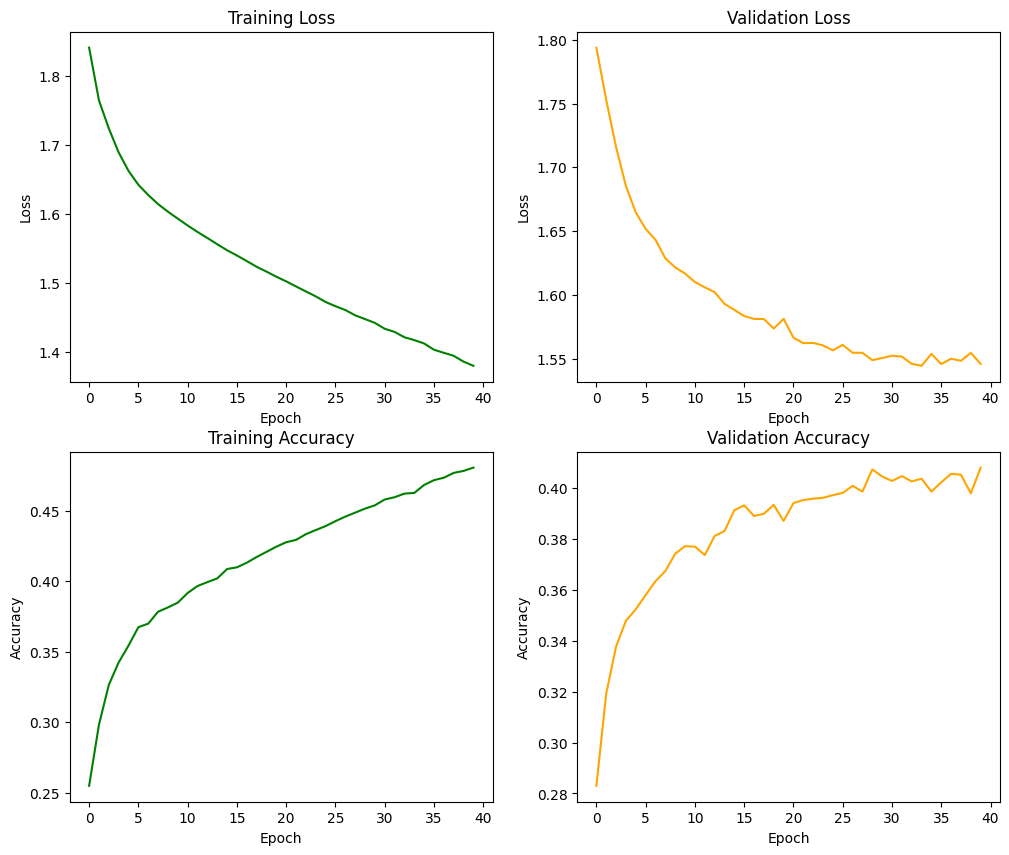

In [48]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(12, 10))

ax[0, 0].plot(train_losses, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_accs, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_accs, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()


In [51]:
test_target = []
test_predict = []
model.eval()
with torch.no_grad():
    for X_samples, y_samples in test_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        outputs = model(X_samples)

        test_predict.append(outputs.cpu())
        test_target.append(y_samples.cpu())

    test_predict = torch.cat(test_predict)
    test_target = torch.cat(test_target)
    test_acc = compute_accuracy(test_predict, test_target)

    print('Evaluation on val set:')
    print(f'Accuracy: {test_acc}')

Evaluation on val set:
Accuracy: 0.41543605461131233
